In [1]:
# !pip install tensorflow

In [2]:
# !pip install gensim

In [3]:
# !pip install transformers

In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout,Flatten
from transformers import BertTokenizer, TFBertModel
from gensim.models.fasttext import FastText
from sklearn.metrics import classification_report
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras import backend as K
from keras import Model
from tensorflow.keras.layers import Layer,SimpleRNN,Input,Attention

In [10]:
def read_text_files(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            text = file.read()
            texts.append(text)
    return texts

# Read texts from each folder
texts_class_0 = read_text_files('class_0')
texts_class_1 = read_text_files('class_1')
texts_class_2 = read_text_files('class_2')
texts_class_3 = read_text_files('class_3')
texts_class_4 = read_text_files('class_4')

# Combine all texts and corresponding labels
texts = texts_class_0 + texts_class_1 + texts_class_2 + texts_class_3 + texts_class_4
labels = [0]*len(texts_class_0) + [1]*len(texts_class_1) + [2]*len(texts_class_2) + [3]*len(texts_class_3) + [4]*len(texts_class_4)

# Perform text preprocessing (stopword removal, TF-IDF vectorization, etc.)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(texts).toarray()

# Word embedding using FastText
fasttext_model = FastText(sentences=[text.split() for text in texts], vector_size=100, window=5, min_count=1, workers=4)

# Tokenize texts for BERT embedding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True) for text in texts]
X_bert = pad_sequences(tokenized_texts, maxlen=512, dtype="long", value=0, truncating="post", padding="post")

In [11]:
# X_test

In [12]:
# Define model architectures for CNN and BiRNN
def create_cnn_model(input_shape):
    model = Sequential([
        Embedding(input_dim=input_shape[1], output_dim=100, input_length=input_shape[1]),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(pool_size=4),
        Flatten(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='softmax')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])
    return model

def create_birnn_model(input_shape):
    model = Sequential([
        Embedding(input_dim=input_shape[1], output_dim=100, input_length=input_shape[1]),
        Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dense(1, activation='softmax')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])
    return model

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(RNN_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')    
    return model    

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)

# Train and evaluate CNN model
cnn_model = create_cnn_model(X_train.shape)
cnn_model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32, validation_data=(np.array(X_test), np.array(y_test)))

# Train and evaluate BiRNN model
birnn_model = create_birnn_model(X_train.shape)
birnn_model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32, validation_data=(np.array(X_test), np.array(y_test)))

time_steps = np.array(X_train).shape[1]
hidden_units = 2
epochs = 30

model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1, 
                                  input_shape=(time_steps,1), activation='tanh')
model_attention.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=32, validation_data=(np.array(X_test), np.array(y_test)))


Epoch 1/10
2/2 [==============================] - 1s 399ms/step - loss: 0.3795 - accuracy: 0.2292 - precision_2: 0.4583 - recall_2: 1.0000 - val_loss: -1.3286 - val_accuracy: 0.3077 - val_precision_2: 0.6154 - val_recall_2: 1.0000
Epoch 2/10
2/2 [==============================] - 0s 172ms/step - loss: 0.3451 - accuracy: 0.2292 - precision_2: 0.4583 - recall_2: 1.0000 - val_loss: -1.9864 - val_accuracy: 0.3077 - val_precision_2: 0.6154 - val_recall_2: 1.0000
Epoch 3/10
2/2 [==============================] - 0s 185ms/step - loss: 0.8333 - accuracy: 0.2292 - precision_2: 0.4583 - recall_2: 1.0000 - val_loss: -2.1770 - val_accuracy: 0.3077 - val_precision_2: 0.6154 - val_recall_2: 1.0000
Epoch 4/10
2/2 [==============================] - 0s 204ms/step - loss: 0.5018 - accuracy: 0.2292 - precision_2: 0.4583 - recall_2: 1.0000 - val_loss: -1.4609 - val_accuracy: 0.3077 - val_precision_2: 0.6154 - val_recall_2: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 212ms/step - loss: 0.22

In [13]:
# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cf= classification_report(y_pred,y_test)

    conf_matrix = confusion_matrix(y_pred,y_test)
    sns.heatmap(conf_matrix,annot=True,cmap='coolwarm')
    return accuracy, f1, precision, recall,cf


C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

CNN Model Metrics:
Accuracy: 0.38461538461538464, F1 Score: 0.21367521367521367, Precision: 0.14792899408284024, Recall: 0.38461538461538464
Accuracy,Precision,Recall and F1 score for each class
              precision    recall  f1-score   support

           0       1.00      0.38      0.56        13
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.38        13
   macro avg       0.20      0.08      0.11        13
weighted avg       1.00      0.38      0.56        13



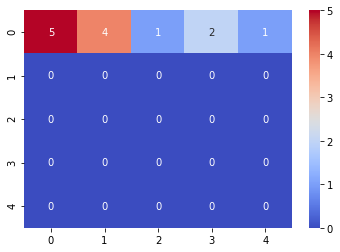

In [14]:
cnn_accuracy, cnn_f1, cnn_precision, cnn_recall,cnn_cf = evaluate_model(cnn_model, X_test, y_test)

print("CNN Model Metrics:")
print(f"Accuracy: {cnn_accuracy}, F1 Score: {cnn_f1}, Precision: {cnn_precision}, Recall: {cnn_recall}")
print(f"Accuracy,Precision,Recall and F1 score for each class\n{cnn_cf}")

C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

BiRNN Model Metrics:
Accuracy: 0.38461538461538464, F1 Score: 0.21367521367521367, Precision: 0.14792899408284024, Recall: 0.38461538461538464
Accuracy,Precision,Recall and F1 score for each class
              precision    recall  f1-score   support

           0       1.00      0.38      0.56        13
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.38        13
   macro avg       0.20      0.08      0.11        13
weighted avg       1.00      0.38      0.56        13



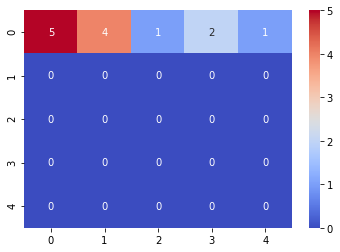

In [15]:
birnn_accuracy, birnn_f1, birnn_precision, birnn_recall,birnn_cf = evaluate_model(birnn_model, X_test, y_test)

print("BiRNN Model Metrics:")
print(f"Accuracy: {birnn_accuracy}, F1 Score: {birnn_f1}, Precision: {birnn_precision}, Recall: {birnn_recall}")
print(f"Accuracy,Precision,Recall and F1 score for each class\n{birnn_cf}")


C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajwal\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

Attention Model Metrics:
Accuracy: 0.38461538461538464, F1 Score: 0.21367521367521367, Precision: 0.14792899408284024, Recall: 0.38461538461538464
Accuracy,Precision,Recall and F1 score for each class
              precision    recall  f1-score   support

           0       1.00      0.38      0.56        13
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.38        13
   macro avg       0.20      0.08      0.11        13
weighted avg       1.00      0.38      0.56        13



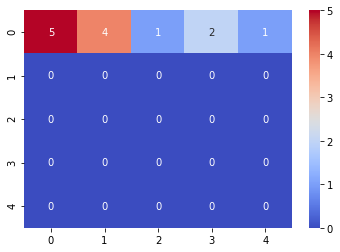

In [16]:
att_accuracy, att_f1, att_precision, att_recall,att_cf = evaluate_model(model_attention, X_test, y_test)

print("Attention Model Metrics:")
print(f"Accuracy: {att_accuracy}, F1 Score: {att_f1}, Precision: {att_precision}, Recall: {att_recall}")
print(f"Accuracy,Precision,Recall and F1 score for each class\n{att_cf}")
